In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

import types

In [3]:
STORAGE_PATH = "../../persisted_data/feather/{}.feather"

def load_data_set(name):
    data = pd.read_feather(STORAGE_PATH.format(name))
    return data

In [13]:
# get some data sets
ibm = load_data_set("IBM_normalized")
jnj = load_data_set("JNJ_normalized")
nasdaq_samples = load_data_set("nasdaq20spy_30shift_normalized")

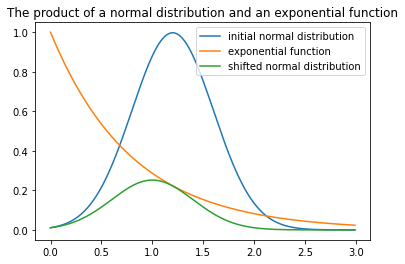

In [14]:
# this function demonstrates the functionality used in data_set_modifier to change the mean of a normal distribution
# a log normal distribution can be shifted the same way, the log has to be taken before this process
def shift_normal(mean=1.1, new_mean=1, std=0.4):
    x = np.arange(0, 3, .01)
    factor = np.exp(-(np.power(mean, 2) - np.power(new_mean, 2)) / (2 * np.power(std, 2)))
    f = factor * np.exp((np.power(x - mean, 2) - np.power(x - new_mean, 2)) / (2 * np.power(std, 2)))
    norm = stats.norm.pdf(x, mean, std)
    plt.title("The product of a normal distribution and an exponential function")
    plt.plot(x, norm)
    plt.plot(x, f)
    plt.plot(x, f * norm)
    plt.legend(["initial normal distribution", "exponential function", "shifted normal distribution"])
    plt.show()
    
# show example functions used in the operation
shift_normal(1.2, 1)

In [15]:
# the mean of a feature is usually not 1
# with this function the distribution of a value in a set of samples can be shifted, by removing some samples
def move_dataset_to_mean(samples, desired_mean=1, feature="future_price", start_of_deletions=lambda x: 0):
    # we want to shift a log normal distribution
    # to simplify this process we take the logarithm and treat the distribution as a normal distribution from now on
    y_log = np.log(samples[feature])

    # calculate the characteristic values of the normal distribution
    mean = np.mean(y_log)
    std = np.std(y_log)

    # define a "start" of the exponential function by setting the point where the keep probability should be = 1
    start = start_of_deletions(y_log) if isinstance(start_of_deletions, types.LambdaType) else start_of_deletions

    # define the probability distribution which is used to shift the sample distribution
    keep_probability = lambda x: np.exp(
        (np.power(x + start - mean, 2) - np.power(x + start - np.log(desired_mean), 2)) / (2 * np.power(std, 2)))

    # create a set of random numbers between 0 and 1
    random_sample = np.random.random_sample(len(samples))
    # define which samples will be kept
    keep = random_sample < keep_probability(y_log)

    return samples[keep]

In [16]:
# simple function used to plot a distribution of values using a histogram
def plot_distribution(y_values, xlabel="future price in relation to current price", ylabel="number of occurrences"):
    size = len(y_values)
    n_bins = min(int(size / 10), 100)
    plt.hist(y_values, bins=n_bins)
    plt.axvline(y_values.mean(), color="red", linestyle="dashed")
    plt.tight_layout()
    plt.title("Distribution plot with sample size {}".format(size))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

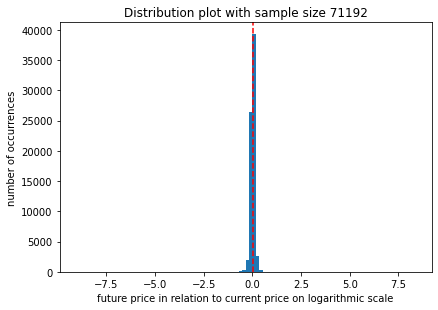

original number of samples: 71192, average: 0.013967492861594506, std: 27.040881303936494


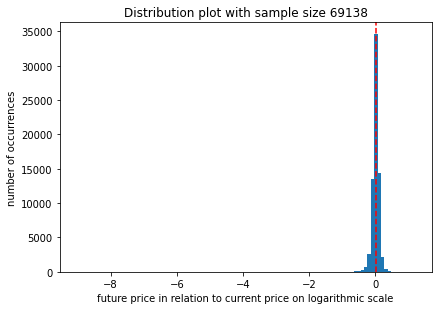

modified number of samples: 69138, average: 0.009869591111339952, std: 0.12206966103268563


In [17]:
def show_shift_data_set(samples):
    # plot the distribution before and after shifting it
    samples_mean = np.mean(np.log(samples["future_price"]))
    samples_std = np.std(samples["future_price"])
    plot_distribution(np.log(samples["future_price"]), "future price in relation to current price on logarithmic scale")
    print("original number of samples: {}, average: {}, std: {}".format(len(samples), samples_mean, samples_std))
    modified = move_dataset_to_mean(samples)
    modified_mean = np.mean(np.log(modified["future_price"]))
    modified_std = np.std(np.log(modified["future_price"]))
    plot_distribution(np.log(modified["future_price"]), "future price in relation to current price on logarithmic scale")
    print("modified number of samples: {}, average: {}, std: {}".format(len(modified), modified_mean, modified_std))

# show how the chart set can be shifted
show_shift_data_set(nasdaq_samples)

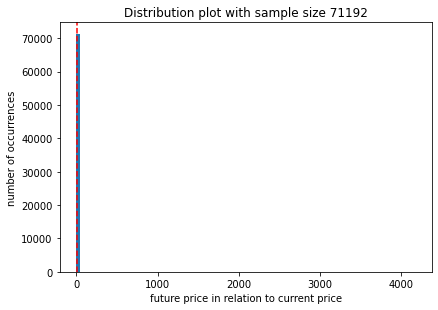

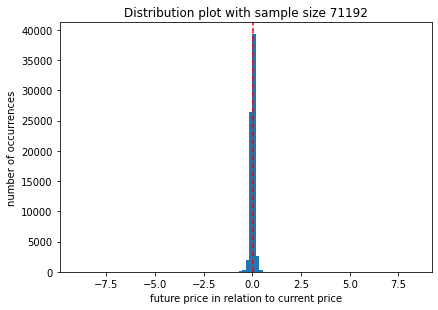

In [18]:
def future_price_log(samples):
    plot_distribution(samples["future_price"])
    plot_distribution(np.log((samples["future_price"])))

# show difference in the distribution of future prices with and without taking the log
future_price_log(nasdaq_samples)

In [12]:
def correlation_with_future(samples):
    correlations = pd.DataFrame()
    for indicator in samples:
        corr = samples[indicator].corr(np.log(samples['future_price']))

        new_row = pd.DataFrame({"indicator": [indicator], "correlation": [corr]})
        correlations = correlations.append(new_row)
    return correlations
                                       
# show the correlation test
correlation_with_future(nasdaq_samples)

,indicator,correlation
0,index,-0.022571
0,volatility10,0.070189
0,volatility20,0.090734
0,volatility50,0.100731
0,volatility100,0.058509
0,volatility200,0.056169
0,sma10,0.049873
0,sma20,0.059362
0,sma50,0.080638
0,sma100,0.079045


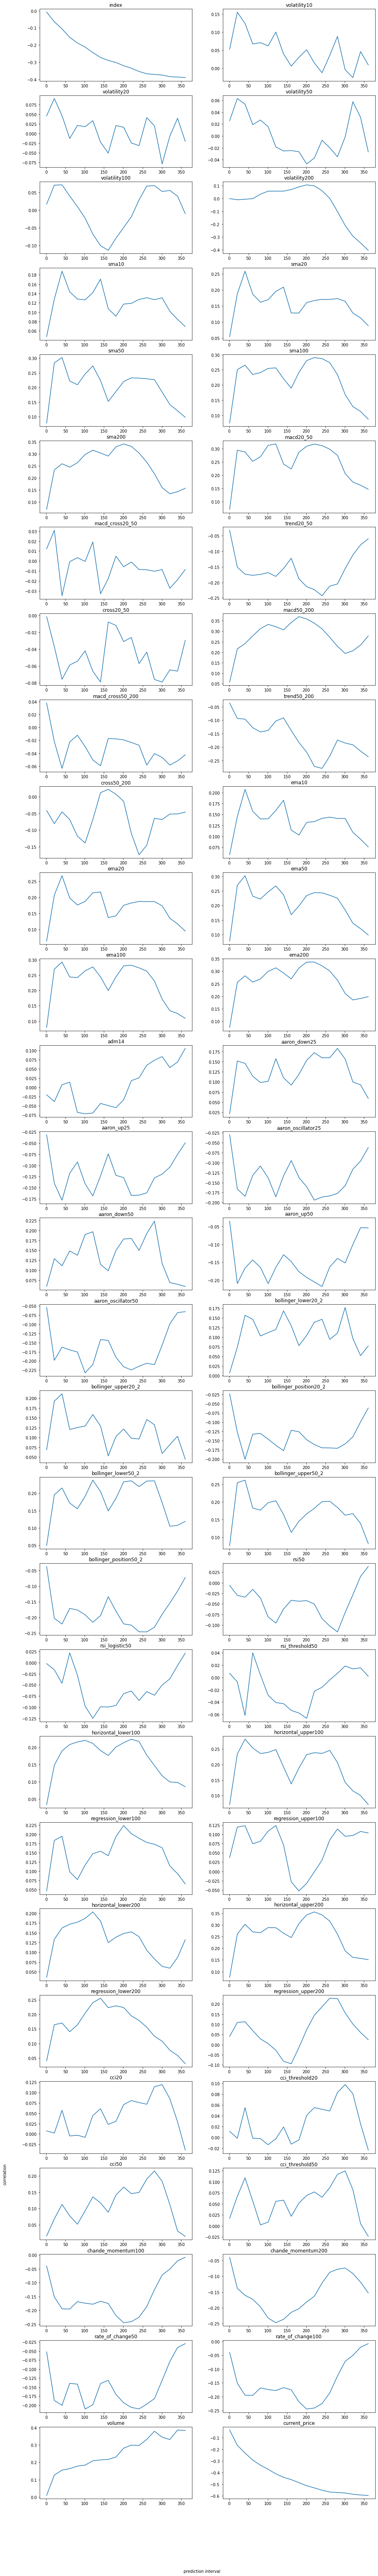

In [19]:
def plot_correlations(intervals, correlations, plot_columns=2):
    number_of_indicators = len(correlations)
    fig, axs = plt.subplots(number_of_indicators // plot_columns + number_of_indicators % plot_columns, plot_columns, figsize=(15,30))
    fig.text(0.5, 0.04, "prediction interval", ha="center")
    fig.text(0.04, 0.5, "correlation", va="center", rotation="vertical")
    for index, indicator in enumerate(correlations):
        axs[index // plot_columns][index % plot_columns].title.set_text(indicator)
        axs[index // plot_columns][index % plot_columns].plot(intervals, correlations[indicator])
    
    plt.subplots_adjust(top=3)
    plt.show()

In [ ]:
# TODO This can not be done like this anymore
"""def analyze_indicator_correlation(samples, prediction_interval_min=1, prediction_interval_max=365, prediction_interval_step_size=20):
    intervals = np.arange(prediction_interval_min, prediction_interval_max, prediction_interval_step_size)
    
    correlations = dict.fromkeys(samples.columns, np.array([]))
    for interval in intervals:
        for feature in samples.keys():
            correlation = samples[feature].corr(samples['current_price'].shift(-interval) / samples['current_price'])
            correlations[feature] = np.append(correlations[feature], correlation)
    plot_correlations(intervals, correlations)

analyze_indicator_correlation(jnj)"""
